In [1]:
import os
import torch
from torchvision.transforms import v2
from torchvision.ops import batched_nms
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import UCF24, HMDB21

from baseline_model import Baseline, PostProcess, PostProcessViz

import torch.nn.functional as F
from torch import nn

from util.box_ops import box_cxcywh_to_xyxy
from util.misc import reduce_dict
from torchmetrics.detection import MeanAveragePrecision
import numpy as np
import cv2
import matplotlib.pyplot as plt

from pprint import pprint

device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
################
# Load Dataset #
################
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
unnormalize = v2.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

video_input_num_frames = 9

num_workers = 4
tfs = v2.Compose([v2.Resize((240, 320)), v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = torch.stack(batch[0])
    return tuple(batch)

argsUCF24 = '/home/sia/UCF-101'
argsANNOUCF24 = 'anno/UCF101v2-GT.pkl'
argsRATEUCF24 = 7
test_ucf = UCF24(argsUCF24, argsANNOUCF24, transforms = tfs, frames=video_input_num_frames, rate=argsRATEUCF24, split = 'test')

argsHMDB21 = '/home/sia/HMDB21'
argsANNOHMDB21 = 'anno/JHMDB-GT.pkl'
test_hmdb = HMDB21(argsHMDB21, argsANNOHMDB21, transforms = tfs, frames = video_input_num_frames, split = 'test')
postprocess = PostProcess()
postprocessviz = PostProcessViz()

ucf_captions = test_ucf.classes
ucf_captionstoidx = {v: k for k, v in enumerate(ucf_captions)}
jhmdb_captions = test_hmdb.classes
jhmdb_captionstoidx = {v: k for k, v in enumerate(jhmdb_captions)}

test dataset (ucf24) loaded!
test dataset (hmdb21) loaded!


In [3]:
#################
# Load Pipeline #
#################
from transformers import AutoImageProcessor, AutoModelForObjectDetection
image_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")
from bytetrack.byte_tracker import BYTETracker
from viclip import get_viclip
import torchvision.transforms.functional as visionF
vlm = get_viclip('b', 'viclip/ViCLIP-B_InternVid-FLT-10M.pth')['viclip']
_ = vlm.eval()

base = Baseline(model, vlm)
_ = base.to(device)

/home/sia/cap5415_ovact/viclip/viclip.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrain, map_location='cpu')['model']


Basketball


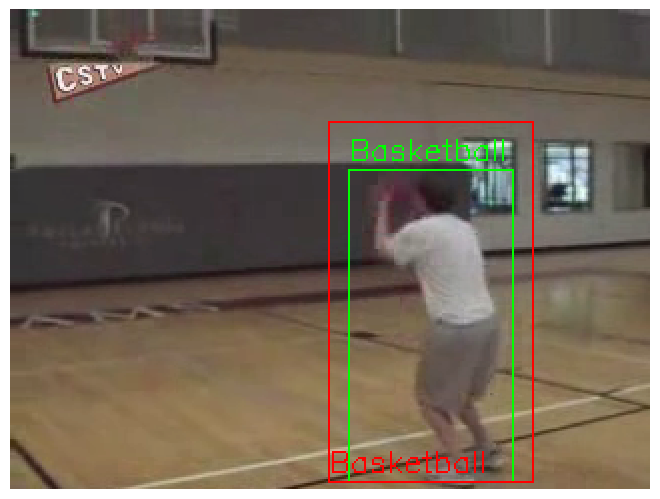

In [43]:
# Viz for UCF-101-24
idx = 0
sample, gt = test_ucf[idx]
H, W = sample.shape[-2:]

# captionstoidx
captionstoidx = {v: k for k, v in enumerate(ucf_captions)}
gt['boxes'] = gt['boxes'].to(device)
intlabels = [list(map(lambda x:captionstoidx[x], ele)) for ele in gt['text_labels']]
gt['labels'] = intlabels

out = base(sample.unsqueeze(0).to(device), ucf_captions)

keyframe = (unnormalize(sample[9//2]).permute(1,2,0) * 255).int().numpy()

# plot pred
pred_boxes = out[0]['pred_boxes']
pred_classes = out[0]['pred_classes']
pred_labels = [ucf_captions[ele] for ele in pred_classes]
for i in range(len(pred_boxes)):
    box = pred_boxes[i]
    #box = pred_boxes[i].cpu().detach().numpy()
    label = pred_labels[i]
    print(label)
    start_point = (box[0], box[1])
    end_point = (box[2], box[3])
    color = (0, 255, 0)
    thickness = 1
    font=0.5
    keyframe = cv2.rectangle(keyframe, start_point, end_point, color, thickness)
    offset = -5
    keyframe = cv2.putText(keyframe, label, (box[0], box[1]+offset), cv2.FONT_HERSHEY_SIMPLEX, font, color, thickness, cv2.LINE_AA)

# plot gt
gt_boxes = box_cxcywh_to_xyxy(gt['boxes'])
gt_boxes[:,0::2] = gt_boxes[:,0::2] * 320
gt_boxes[:,1::2] = gt_boxes[:,1::2] * 240
gt_labels = gt['text_labels']
for i in range(len(gt_boxes)):
    #box = gt_boxes[i]
    box = gt_boxes[i].cpu().detach().int().numpy()
    label = gt_labels[i]
    start_point = (box[0], box[1])
    end_point = (box[2], box[3])
    color = (255, 0, 0)
    thickness = 1
    font=0.5
    keyframe = cv2.rectangle(keyframe, start_point, end_point, color, thickness)
    #offset = 10
    
    for act in label:
        keyframe = cv2.putText(keyframe, act, (box[0], box[3]+offset), cv2.FONT_HERSHEY_SIMPLEX, font, color, thickness, cv2.LINE_AA)
        offset -= 10
    


plt.imshow(keyframe)
plt.gca().set_axis_off()
plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
plt.margins(0,0)

brush hair


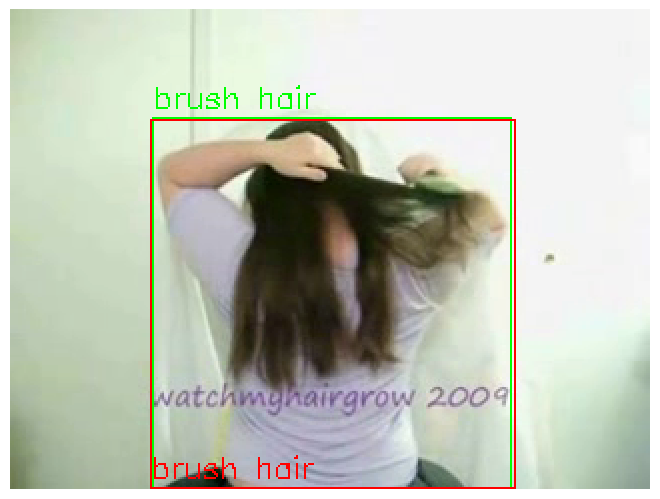

In [40]:
# Viz for JHMDB
idx=1
sample, gt = test_hmdb[idx]
H, W = sample.shape[-2:]

# captionstoidx
captionstoidx = {v: k for k, v in enumerate(jhmdb_captions)}
gt['boxes'] = gt['boxes'].to(device)
intlabels = [list(map(lambda x:captionstoidx[x], ele)) for ele in gt['text_labels']]
gt['labels'] = intlabels

out = base(sample.unsqueeze(0).to(device), jhmdb_captions)

keyframe = (unnormalize(sample[9//2]).permute(1,2,0) * 255).int().numpy()

# plot pred
pred_boxes = out[0]['pred_boxes']
pred_classes = out[0]['pred_classes']
pred_labels = [jhmdb_captions[ele] for ele in pred_classes]
for i in range(len(pred_boxes)):
    box = pred_boxes[i]
    #box = pred_boxes[i].cpu().detach().numpy()
    label = pred_labels[i]
    print(label)
    start_point = (box[0], box[1])
    end_point = (box[2], box[3])
    color = (0, 255, 0)
    thickness = 1
    font=0.5
    keyframe = cv2.rectangle(keyframe, start_point, end_point, color, thickness)
    offset = -5
    keyframe = cv2.putText(keyframe, label, (box[0], box[1]+offset), cv2.FONT_HERSHEY_SIMPLEX, font, color, thickness, cv2.LINE_AA)

# plot gt
gt_boxes = box_cxcywh_to_xyxy(gt['boxes'])
gt_boxes[:,0::2] = gt_boxes[:,0::2] * 320
gt_boxes[:,1::2] = gt_boxes[:,1::2] * 240
gt_labels = gt['text_labels']
for i in range(len(gt_boxes)):
    #box = gt_boxes[i]
    box = gt_boxes[i].cpu().detach().int().numpy()
    label = gt_labels[i]
    start_point = (box[0], box[1])
    end_point = (box[2], box[3])
    color = (255, 0, 0)
    thickness = 1
    font=0.5
    keyframe = cv2.rectangle(keyframe, start_point, end_point, color, thickness)
    #offset = 10
    
    for act in label:
        keyframe = cv2.putText(keyframe, act, (box[0], box[3]+offset), cv2.FONT_HERSHEY_SIMPLEX, font, color, thickness, cv2.LINE_AA)
        offset -= 10
    


plt.imshow(keyframe)
plt.gca().set_axis_off()
plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
plt.margins(0,0)